In [1]:
import numpy as np
import h5py
import os
import glob
from utilityFunctions import load_csv_to_matrix, load_csv_to_matrix_batch, compute_color_preference_raw_batch, compute_color_preference_distance_batch, show_heatmaps, compute_color_similarity_distance_batch, compute_correlations, RSA, split_and_average_matrices, perform_mds_and_plot

In [2]:
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)
folder_path = 'raw_data/202411_data'
response_type = 'preference'

In [3]:
def load_clusters_from_mat_v73(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys:", list(f.keys()))  # Inspect available variables

        clusters = f['clusters']
        # Assume it's a 2x1 cell array, and each cell points to a dataset
        cluster1_ref = clusters[0][0]
        cluster2_ref = clusters[1][0]

        cluster1 = np.array(f[cluster1_ref]).astype(int).flatten()
        cluster2 = np.array(f[cluster2_ref]).astype(int).flatten()

        return cluster1, cluster2


In [4]:
cluster1, cluster2 = load_clusters_from_mat_v73('raw_data/clusters_preference_raw.mat')
print(cluster1)
print(cluster2)

Keys: ['#refs#', 'clusters', 'participants', 'process_type', 'rating_type']
[ 1 15 12  7 11  5  8 10  4 13 18]
[ 2 19  6  3 16  9 14 17]


In [5]:
cluster_1_matrices = []
for subject_id in cluster1:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    
    cluster_1_matrices.append(matrix)

cluster_1_matrices_preference_distance = compute_color_preference_distance_batch(cluster_1_matrices, value_range_max = 3.5)

cluster_2_matrices = []
for subject_id in cluster2:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_2_matrices.append(matrix)

cluster_2_matrices_preference_distance = compute_color_preference_distance_batch(cluster_2_matrices, value_range_max = 3.5)

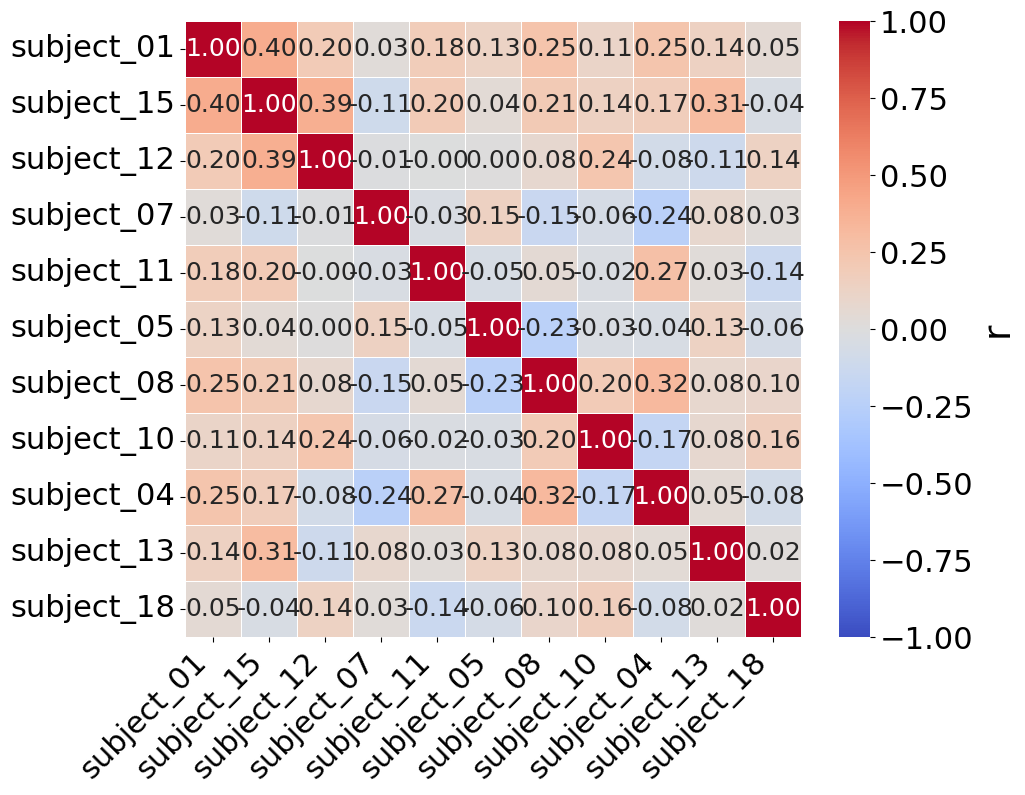

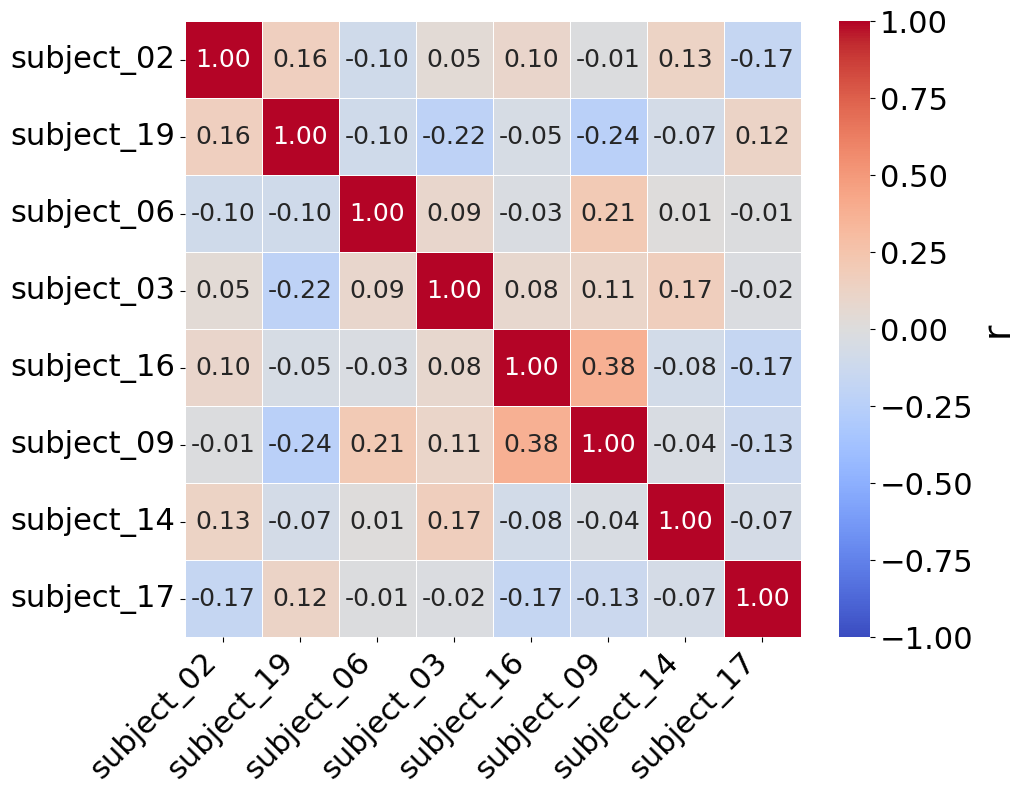

(array([[ 1.        ,  0.16310081, -0.09541425,  0.04516435,  0.09901691,
         -0.00991342,  0.12966538, -0.16949003],
        [ 0.16310081,  1.        , -0.09758136, -0.21579383, -0.04912226,
         -0.23610121, -0.07363997,  0.12301357],
        [-0.09541425, -0.09758136,  1.        ,  0.09105879, -0.02955271,
          0.20859733,  0.0113343 , -0.01451914],
        [ 0.04516435, -0.21579383,  0.09105879,  1.        ,  0.08321388,
          0.10880526,  0.1675119 , -0.01640421],
        [ 0.09901691, -0.04912226, -0.02955271,  0.08321388,  1.        ,
          0.37780251, -0.0837948 , -0.16676984],
        [-0.00991342, -0.23610121,  0.20859733,  0.10880526,  0.37780251,
          1.        , -0.03719173, -0.12666069],
        [ 0.12966538, -0.07363997,  0.0113343 ,  0.1675119 , -0.0837948 ,
         -0.03719173,  1.        , -0.06751132],
        [-0.16949003,  0.12301357, -0.01451914, -0.01640421, -0.16676984,
         -0.12666069, -0.06751132,  1.        ]]),
 ['subject_02'

In [6]:
cluster1_dict = {f"subject_{i:02d}": m for i, m in zip(cluster1, cluster_1_matrices_preference_distance)}
cluster2_dict = {f"subject_{i:02d}": m for i, m in zip(cluster2, cluster_2_matrices_preference_distance)}

compute_correlations(cluster1_dict)
compute_correlations(cluster2_dict)

In [7]:
stacked_1 = np.stack(cluster_1_matrices_preference_distance)  # Shape: (n_subjects, matrix_size, matrix_size)
cluster_1_mean_preference_distance = np.mean(stacked_1, axis=0)

stacked_2 = np.stack(cluster_2_matrices_preference_distance)  
cluster_2_mean_preference_distance = np.mean(stacked_2, axis=0)

In [8]:
cluster_1_mean_preference_distance

array([[0.86363636, 1.13636364, 1.36363636, 1.63636364, 2.5       ,
        2.27272727, 2.13636364, 1.95454545, 1.5       , 1.90909091,
        1.45454545, 1.54545455],
       [1.13636364, 0.95454545, 1.59090909, 2.        , 1.81818182,
        2.22727273, 2.09090909, 2.31818182, 2.04545455, 1.5       ,
        1.40909091, 1.40909091],
       [1.36363636, 1.59090909, 0.95454545, 1.45454545, 1.72727273,
        2.27272727, 2.13636364, 2.22727273, 1.59090909, 1.72727273,
        1.36363636, 1.27272727],
       [1.63636364, 2.        , 1.45454545, 1.31818182, 1.68181818,
        1.86363636, 1.22727273, 1.68181818, 1.86363636, 1.54545455,
        1.95454545, 1.77272727],
       [2.5       , 1.81818182, 1.72727273, 1.68181818, 1.04545455,
        1.59090909, 1.63636364, 1.90909091, 1.90909091, 1.5       ,
        1.63636364, 1.90909091],
       [2.27272727, 2.22727273, 2.27272727, 1.86363636, 1.59090909,
        1.40909091, 1.81818182, 1.77272727, 1.81818182, 1.86363636,
        1.90909091,

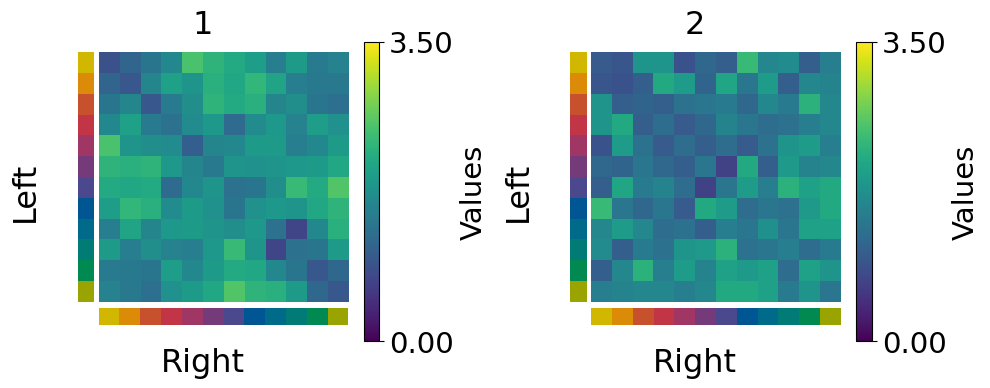

In [9]:
show_heatmaps(vmin_val=0, vmax_val=3.5, matrices=[cluster_1_mean_preference_distance, cluster_2_mean_preference_distance], titles=list(range(1, 3)), nrows=1, ncols=2, cmap_name="viridis", cbar_label="Values", color_labels=unique_colours)

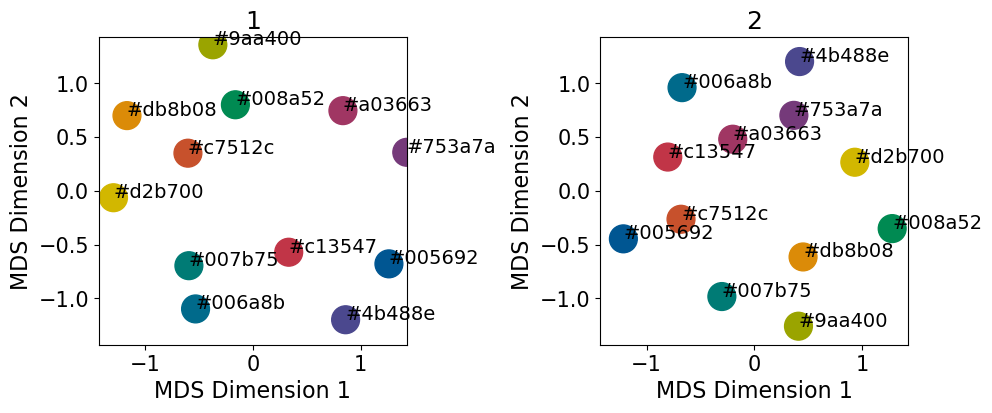

In [10]:
perform_mds_and_plot(matrices = [cluster_1_mean_preference_distance, cluster_2_mean_preference_distance], titles = list(range(1, 3)), colour_index = colour_index, n_rows = 1, n_cols = 2, n_components=2)